<a href="https://colab.research.google.com/github/BernadetteCB/fedkmeans/blob/main/FedKMeansShared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes and imports

## Note
All functions inbetween rows of hashes are written by Oskar J. Triebe of Stanford University, taken from python scripts in the GitHub repository https://github.com/ourownstory/federated_kmeans/tree/master

## Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import random
import datetime
import math

In [ ]:
from google.colab import files

# Creating a dummy dataset

To begin, I must create a dummy data set that contains a list of 100 total clients, each with 7 samples corresponding to a day of the week. All samples contains 24 data points corresponding to an hour of the day.  

File x.csv contains all sample values and house_ids.csv contains all client IDs from 0 to 99 repeated 7 times - one entry for each sample.  

This dataset simulates the structure of a PECAN street dataset in that each client represents a house with samples of electricity use over time. It was created using the "creat_dummy_data" function. This kind of dummy data is often used for benchmarking of real PECAN data.

In [ ]:
## Generate PECAN data

#####################
# From utils_data.py:

def create_dummy_data(dims=24, clients_per_cluster=10, samples_each=7, clusters=10, scale=0.5, verbose=False):
    num_clients = clients_per_cluster * clusters
    # create gaussian data set, per client one mean
    means = np.arange(1, clusters+1)
    means = np.tile(A=means, reps=clients_per_cluster)
    noise = np.random.normal(loc=0.0, scale=scale, size=(num_clients, samples_each, dims))
    data = np.expand_dims(means, axis=(1,2)) + noise # creates negative energy usage values
    data = np.clip(data, 0, None) # corrects negative energy usage due to noise
    if verbose:
        # print(means)
        # print(noise)
        print("Dummy data shape: ", data.shape)
    data = [data[i] for i in range(num_clients)]
    return data, means

#######################

# create_dummy_data() params:
dims=24
clients_per_cluster=10
samples_each=7
clusters=10
scale=0.5
verbose=False

# Create folders if non-existent:
base_dir=os.path.join(os.getcwd(), 'data')
train_dir=os.path.join(base_dir, 'pecan_train')
test_dir=os.path.join(base_dir, 'pecan_test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Generate training data:
train_data,train_means = create_dummy_data(dims, clients_per_cluster, samples_each, clusters, scale)

train_flat = np.vstack(train_data) # shape=(num_clients*samples_each)
train_ids = np.repeat(np.arange(len(train_means)), samples_each)

# Save train CSV files:
pd.DataFrame(train_flat).to_csv(os.path.join(train_dir,'x.csv'), index=False, header=False)
pd.DataFrame(train_ids).to_csv(os.path.join(train_dir,'house_ids.csv'), index=False, header=False)

# Generate test dummy data:
test_data,test_means=create_dummy_data(dims,
                                       clients_per_cluster=clients_per_cluster,
                                       samples_each=samples_each,
                                       clusters=clusters,
                                       scale=scale,
                                       verbose=False)

test_flat, test_means = create_dummy_data(dims, clients_per_cluster, samples_each, clusters, scale)

test_flat = np.vstack(test_data) # shape=(num_clients*samples_each)
test_ids = np.repeat(np.arange(len(test_means)), samples_each)

# Save test CSV files:
pd.DataFrame(test_flat).to_csv(os.path.join(test_dir,'x.csv'), index=False, header=False)
pd.DataFrame(test_ids).to_csv(os.path.join(test_dir,'house_ids.csv'), index=False, header=False)

print(f'Train data: {train_flat.shape}, House IDs: {train_ids.shape}')
print(f'Test data: {test_flat.shape}, House IDs: {test_ids.shape}')
print(f'CSV files saved in {train_dir} and {test_dir}.')

Train data: (700, 24), House IDs: (700,)
Test data: (700, 24), House IDs: (700,)
CSV files saved in /content/data/pecan_train and /content/data/pecan_test.


# Loading the federated dataset
Here, I load and visulaise the dataset. All clients' data are represented in the figure below. It has a clear, discrete structure.

Data shape from train CSV: (700, 24)
Number of clients in 'train': 100
Data shape from test CSV: (700, 24)
Number of clients in 'test': 100


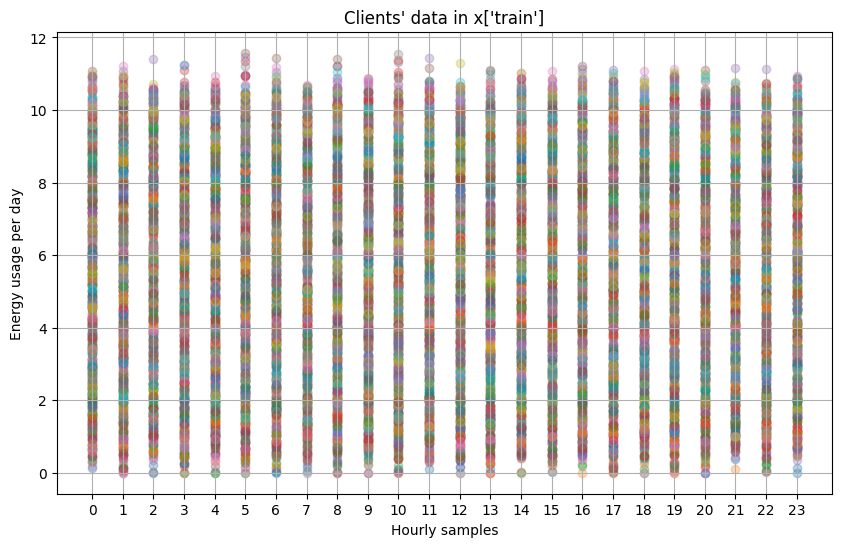

In [ ]:
## Load federated data

#####################
# Edited from utils_data.py:

def load_federated(limit_csv=None, verbose=False, seed=None, clusters=None):
    return load_federated_real(limit_csv, verbose, seed)

def load_federated_real(limit_csv=None, verbose=False, seed=None):
    np.random.seed(seed)
    x = {}
    client_ids = {}
    for spl in ['train', 'test']:
        path = os.path.join(project_dir, "data", "pecan_{}".format(spl))
        data = pd.read_csv(
            os.path.join(path, "x.csv"),
           # index_col=False,
            header=None,
            nrows=limit_csv
        )
        print(f"Data shape from {spl} CSV:", data.shape)
        house_ids = pd.read_csv(
            os.path.join(path, "house_ids.csv"),
           # index_col=False,
            header=None,
            nrows=limit_csv
        ).values[:, 0]

        data['house_id'] = house_ids

        # group by, return as list
        df=data.groupby('house_id',sort=True)
        x[spl]=[group.drop(columns='house_id').values for _, group in df]
        client_ids[spl]=[client_id for client_id, _ in df]

        print(f"Number of clients in '{spl}': {len(x[spl])}")

    if verbose:
        fig, ax = plt.subplots(figsize=(10,6))

        for client_idx,client_data in enumerate(x['train']): # loop all clients
          for day in client_data:
            plt.scatter(
                range(24), # x-axis
                day, # y-axis
                alpha=0.3,
              #  label=f'Client {client_idx}' # if client_idx<10 else None
            )
        ax.set_xticks(np.arange(0,24,1))
        plt.title(f"Clients' data in x['train']")
        plt.xlabel('Hourly samples')
        plt.ylabel('Energy usage per day')
        plt.grid(True)
        title=datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        plt.show()

    return x, client_ids

#####################

project_dir = os.getcwd()

# Run load fedarated function:
x,ids = load_federated(verbose=True)

# Scaling the client data
Note: I am no longer scaling the data. This has lead to better separation of data points. This is likely due to the natural variation in energy usage aiding separation of data points such that they may form more meaningful clusters.

---

I use Sci-Kit Learn's standard scler function to scale the client training data. Although this is dummy data, data from real households may reflect different energy usage on any given day. For exmaple, larger homes with more residents are likely to use more kilowatt hours per day than a smaller house with fewer residents. Scaling standardises the energy usage across these homes.  

Consequently, this prevents homes that use more kilowatt hours per day distorting the calculation of centroids due to their higher variance. It also prevents these households from dominating the model and unfairly affecting the resulting training gradients.

In [ ]:
## Scale client data
#
#for i, client_data in enumerate(x['train']):
#    scaler = StandardScaler()
#    x['train'][i] = scaler.fit_transform(client_data)
#
#print(f"Number of training clients: {len(x['train'])}.")
#print(f"Shape of first training client's data: {x['train'][0].shape}.")

# Defining functions for the execution of the k-means clustering algorithm
Functions inside rows of hashes, although edited, are taken from python scripts produced by the aforementioned Oskar J. Triebe. They are included in this file (instead of using the magic command 'run') to allow for execution on any computer without requiring a specific directory setup.  

Similarly, functions inside rows of quotation marks are edited versions of those found at https://www.geeksforgeeks.org/ml-k-means-algorithm/.

## Plotting functions and initiating centroids

I altered Oskar's functions to use k-means++ for centroid initialisation using code from https://www.geeksforgeeks.org/ml-k-means-algorithm/  

K-means++ assigns more appropriate initial centroids using the following method:


1.   cluster 1 is assigned a random centroid chosen from its data points;
2.   distances between all data points in cluster 2 and the centroid in cluster 1 are calculated, and the data point with the greatest distance is assigned as cluster 2's centroid;
3.   the centroids for all subsequent centroids $n+1$ are chosen in the same manner, except the data points are compared to the nearest pre-existing centroid instead of the centroid for cluster $n$.  

Using k-means++ negates the negative effects of randomness on cluster formation. In practical terms, it has prevented the outcome where clients are not assigned data.  

Altering code from the same website as above, I created two plotting functions to visualise the data points in each cluster and their centroids.  

The first function "plot_initial" visualises the k-means++ process of choosing initial centroids, and the second function "plot_final" visualises the final positions of those centroids after k-means clustering has taken place.

In [ ]:
""""""
# Edited code from https://www.geeksforgeeks.org/ml-k-means-algorithm/ :

def plot_initial(data, centroids, labels):
  plt.scatter(data[:, 0], data[:, 1], marker='.', color='gray')

  if centroids.shape[0] > 1:
    plt.scatter(centroids[:-1, 0], centroids[:-1, 1], color='black', label='Initiated Centroids')
  plt.scatter(centroids[-1, 0], centroids[-1, 1], color='red', label='Next Centroid')

  titles = {1: 'st', 2: 'nd', 3: 'rd'}
  suffix = titles.get(centroids.shape[0], 'th')
  plt.title(f'Initial {centroids.shape[0]}{suffix} Centroid')
  plt.legend()
  plt.show()

def plot_final(data, centroids, labels):
  cluster_colours = ['lightcoral','mediumslateblue','orchid','lightgreen','powderblue','coral','paleturquoise','navajowhite','pink','khaki','lightsteelblue']

  labels = np.array(labels).flatten()
  for i, label in enumerate(np.unique(labels)):
    cluster_points = data[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], marker='.', color=cluster_colours[label+1], label=f'Cluster {label}')
  plt.scatter(centroids[:, 0], centroids[:, 1], color='black', label='Centroids')

  plt.title('Final Clusters and Centroids')
  plt.legend()
  plt.show()

def k_plus_pluss_init_centroids(data, k, labels=None, seed=None):
  if seed is not None:
    np.random.seed(seed=None)

  centroids = []

  centroids.append(data[np.random.randint(data.shape[0])])
  plot_initial(data, np.array(centroids), labels)

  for i in range (k - 1):
    distances = []
    for point in data:
      min_dist = min([math.dist(point, c) for c in centroids])
      distances.append(min_dist)
    next_centroid = data[np.argmax(distances)]
    centroids.append(next_centroid)
    plot_initial(data, np.array(centroids), labels)

  return np.array(centroids)

""""""

''

## K-means class

The k-means algorithm seeks to group data points into disjoint clusters, each of which are assigned a mean value referred to as the centroid. These centroids are chosen such that the sum of squares is minimised:

$$
\sum_{i=0}^{n} \min_{μ_{j}∈C} ({\left\lVert x_{i} - \mu_{j} \right\rVert}^2), [1]
$$  

where $x_{i}$ is the $i^{th}$ data point in dataset $X$, $\mu_{j}$ is the centroid of cluster $j$, $n$ is the total number of data points, and $C$ is the set of all centroids.  

K-means is a special case of Expectation Maximisation (EM) used in Gaussian Mixture Modelling (GMM), where the components have small, fixed variance that is equal across all clusters, and diagonal covariance matrices showing no correlation between features (e.g. all off-diagonal entries in the covariance matrices are zero). In the context of clustering, k-means assumes that all clusters are spherical.  

Unlike GMM, k-means produces hard assignments to data points instead of assigning a probability that a given data point belongs to a cluster.  

The above description of k-means can be summarised by stating that whilst EM estimates means $μ_{j}$, covariances $∑_{j}$, and mixing coefficients $π_{j}$, k-means estimates only the means.

The minimisation objective [1] is acheived using the following method:

1.   Centroid initialisation - this is often done by randomly choosing points in the data points space, but can also be carried out using initialisation methods such as k-means++ as used in this notebook.
2.   Assigning data points $x_{i}$ to the cluster with the nearest centroid (comparable to the E-step) -

$$
C_{j}^{(t)} = \left\{{{x_{i}∈X \;|\; {\left\lVert x_{i}-μ_{j}^{(t)}\right\rVert}^2} ≤ {\left\lVert x_{i}-μ_{l}^{t} \right\rVert}^2,\; ∀l∈\{1,…,k}\right\}
$$

3.   Updating those centroids by taking the mean of data points assigned to each cluster (comparable to the M-step) -

$$
μ_{j}^{(t+1)}=\frac{1}{|C_{j}^{(t)}|}\; ∑_{x_{i}∈C_{j}^{(t)}} x_{i},\; ∀j=1,2,…,l.
$$

Steps 2 and 3 are then repeated until the difference between the old and updated centroids are below a given threshold.

In [ ]:
class KMeans:
    def __init__(
        self,
        n_clusters,
        init_centroids='random',
        max_iter=100,
        tol=0.0001,
        distance_metric='euclidean',
        seed=None,
        reassign_min=None,
        reassign_after=None,
        verbose=False,
    ):
        self.n_clusters = n_clusters
        self.seed = seed,
        self.init_centroids = init_centroids
        self.max_iter = max_iter
        self.tol = tol
        self.distance_metric = distance_metric
        if distance_metric != 'euclidean':
            raise NotImplementedError
        self.verbose = verbose
        self.reassign_min = reassign_min
        self.reassign_after = reassign_after

    def do_init_centroids(self):
        if isinstance(self.init_centroids, str):
            if self.init_centroids == 'random':
                # # assumes data is in range 0-1
                # centroids = np.random.rand(self.n_clusters, self.n_dims)
                # for dummy data
                centroids = randomly_init_centroid(0, self.n_clusters+1, self.n_dims, self.n_clusters)
            else:
                raise NotImplementedError
        elif self.init_centroids.shape == (self.n_clusters, self.n_dims):
            centroids = self.init_centroids
        else:
            raise NotImplementedError
        return centroids

    def fit(self, X, record_at=None):
        x = X
        self.n_dims = x.shape[1]
        centroids = self.do_init_centroids()
        means_record = []
        stds_record = []
        to_reassign = np.zeros(self.n_clusters)
        for iteration in range(1, 1+self.max_iter):
            # compute distances
            # computationally efficient
            # differences = np.expand_dims(x, axis=1) - np.expand_dims(centroids, axis=0)
            # sq_dist = np.sum(np.square(differences), axis=2)
            # memory efficient
            sq_dist = np.zeros((x.shape[0], self.n_clusters))
            for i in range(self.n_clusters):
                sq_dist[:, i] = np.sum(np.square(x - centroids[i, :]), axis=1)

            labels = np.argmin(sq_dist, axis=1)
            # update centroids
            centroid_updates = np.zeros((self.n_clusters, self.n_dims))

            for i in range(self.n_clusters):
                mask = np.equal(labels, i)
                size = np.sum(mask)
                if size > 0:
                    update = np.sum(x[mask] - centroids[i], axis=0)
                    centroid_updates[i, :] = update / size
                if self.reassign_min is not None:
                    if size < x.shape[0] * self.reassign_min:
                        to_reassign[i] += 1
                    else:
                        to_reassign[i] = 0


            centroids = centroids + centroid_updates
            changed = np.any(np.absolute(centroid_updates) > self.tol)

            for i, num_no_change in enumerate(to_reassign):
                if num_no_change >= self.reassign_after:
                    centroids[i] = randomly_init_centroid(0, self.n_clusters+1, self.n_dims, 1)
                    to_reassign[i] = 0
                    changed = True

            if record_at is not None and iteration in record_at:
                means, stds = record_state(centroids, x)
                means_record.append(means)
                stds_record.append(stds)
            # if not changed:
            #     break

        if record_at is not None:
            #  NOTE: only for dummy data
            plot_progress(means_record, stds_record, record_at)


        # print(sq_dist.shape)
        # print(labels.shape)
        # print(centroids.shape)
        self.cluster_centers_ = centroids
        self.labels_ = labels
        return centroids, labels

    def predict(self, x):
        # memory efficient
        sq_dist = np.zeros((x.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            sq_dist[:, i] = np.sum(np.square(x - self.cluster_centers_[i, :]), axis=1)
        labels = np.argmin(sq_dist, axis=1)
        return labels

## Federated k-means class

A federated variant of k-means clustering uses the method described in the previous section as part of a new method that can be described thusly:

1.  Clients perform k-means clustering locally;
2.  Each client sends their sum of feature vectors, and number of points per cluster (counts) as a central update;
3.  These updates are aggregated and new global centroids, $\mu_{k}^{global}$, are calculated by averaging the sum of feature vectors for each cluster -

$$
\mu_{k}^{global}=\frac{\sum_{i}S_{k}^{(i)}}{\sum_{i}C_{k}^{(i)}},
$$

where $S_{k}^{(i)}$ is the sum of cluster sums across all clients and $C_{k}^{(i)}$ is the sum of counts across all clients. The global centroids are then sent back to the clients and the process iterates until either the difference between the local and global centroids falls below a given threshold, or the maximum number of iterations is reached.

In [ ]:
########################
# Edited from kmeans_python.py:

class KMeansFederated(KMeans):
    def __init__(
            self,
            n_clusters,
          #  init_centroids='random',
            max_iter=100,
            tol=0.0001,
            distance_metric='euclidean',
            seed=None,
            reassign_min=None,
            reassign_after=None,
            verbose=False,
            batch_size=None,
            sample_fraction=1.0,
            epochs_per_round=1,
            learning_rate=None,
            max_no_change=None,
            adaptive_lr=None,
            momentum=None,
            epoch_lr=1,
    ):
        super().__init__(
            n_clusters=n_clusters,
          #  init_centroids=init_centroids,
            max_iter=max_iter,
            tol=tol,
            distance_metric=distance_metric,
            seed=seed,
            reassign_min=reassign_min,
            reassign_after=reassign_after,
            verbose=verbose
        )
        self.batch_size = batch_size
        self.sample_fraction = sample_fraction
        self.epochs = epochs_per_round
        self.lr = learning_rate
        self.adaptive_lr = adaptive_lr
        self.max_no_change = max_no_change
        self.momentum_rate = momentum
        self.epoch_lr = epoch_lr

    def do_federated_round_single_step(self, clients_in_round, centroids):
        updates_sum = np.zeros((self.n_clusters, self.n_dims))
        counts = np.zeros(self.n_clusters)
        for client_data in clients_in_round:
            client_updates_sum, client_counts = compute_step_for_client(
                client_data=client_data,
                centroids=centroids
            )
            # if self.epoch_lr is not None:
            #     client_updates_sum = self.epoch_lr * client_updates_sum
            updates_sum += client_updates_sum
            counts += client_counts
            if self.verbose:
                print("client_counts: {}; \nclient_updates: \n{}".format(client_counts, client_updates_sum))
        return updates_sum, counts

    def do_federated_round(self, clients_in_round, centroids):
        updates_sum = np.zeros((self.n_clusters, self.n_dims))
        counts = np.zeros(self.n_clusters)
        for client_data in clients_in_round:
            client_centroids = centroids
            for e in range(self.epochs):
                client_updates_sum, client_counts = compute_step_for_client(
                    client_data=client_data,
                    centroids=client_centroids
                )
                interim_updates = client_updates_sum / np.expand_dims(np.maximum(client_counts, np.ones_like(client_counts)), axis=1)
                if self.epoch_lr is not None:
                    interim_updates = self.epoch_lr * interim_updates
                client_centroids = client_centroids + interim_updates
            updates_sum += (client_centroids - centroids) * np.expand_dims(client_counts, axis=1)

            counts += client_counts
            if self.verbose:
                print("client_counts: {}; \nclient_updates_sum: \n{}".format(client_counts, client_updates_sum))
        return updates_sum, counts

    def fit(self, X, record_at=None):
        x = X
        self.num_clients = len(x)
        self.n_dims = x[0].shape[1]
        clients_per_round = max(1, int(self.sample_fraction * self.num_clients))

        all_data = np.concatenate(x, axis=0)
        centroids = k_plus_pluss_init_centroids(all_data, self.n_clusters, labels=None, seed=self.seed)

        not_changed = 0
        overall_counts = np.zeros(self.n_clusters)
        momentum = np.zeros_like(centroids)
        means_record = []
        stds_record = []
        to_reassign = np.zeros(self.n_clusters)

        for iteration in range(1, 1+self.max_iter):
            clients_in_round = random.sample(x, clients_per_round)
            if self.verbose:
                print("round: {}".format(iteration))

            updates_sum, counts = self.do_federated_round_single_step(
                clients_in_round=clients_in_round,
                centroids=centroids,
            )

            overall_counts += counts
            updates = updates_sum / np.expand_dims(np.maximum(counts, np.ones_like(counts)), axis=1)

            if self.adaptive_lr:
                rel_counts = counts / np.maximum(overall_counts, np.ones_like(overall_counts))
                update_weights = np.minimum(self.adaptive_lr, rel_counts)
                updates = updates * np.expand_dims(update_weights, axis=1)

            if self.lr is not None:
                updates = self.lr * updates

            if self.momentum_rate is not None:
                momentum = self.momentum_rate * momentum + (1 - self.momentum_rate) * updates
                updates = momentum

            centroids = centroids + updates
            changed = np.any(np.absolute(updates) > self.tol)

            if self.reassign_min is not None:
                for i in range(self.n_clusters):
                  if counts[i] < (sum(counts) * self.reassign_min):
                    to_reassign[i] += 1
                  else:
                    to_reassign[i] = 0
                  if to_reassign[i] >= self.reassign_after:
                    new_centroids = k_plus_pluss_init_centroids(all_data, self.n_clusters, self.seed, labels)
                    centroids[i] = new_centroids[i]
                    momentum[i] = np.zeros(self.n_dims)
                    to_reassign[i] = 0
                    changed = True
                  if self.max_no_change is not None:
                    not_changed += 1
                    if changed:
                      not_changed = 0
                    if not_changed > self.max_no_change:
                      break

            if record_at is not None and iteration in record_at:
              means, stds = record_state(centroids, all_data)
              means_record.append(means)
              stds_record.append(stds)

        self.cluster_centers_ = centroids

        return centroids, overall_counts

########################

## Other functions


In [ ]:
########################
# From kmeans_python.py:

def predict(self, x):
    # memory efficient
    sq_dist = np.zeros((x.shape[0], self.n_clusters))
    for i in range(self.n_clusters):
        sq_dist[:, i] = np.sum(np.square(x - self.cluster_centers_[i, :]), axis=1)
    labels = np.argmin(sq_dist, axis=1)
    return labels

def compute_step_for_client(client_data, centroids):
    # compute distances
    # computationally efficient
    differences = np.expand_dims(client_data, axis=1) - np.expand_dims(centroids, axis=0)
    sq_dist = np.sum(np.square(differences), axis=2)

    # memory efficient
    # sq_dist = np.zeros((client_data.shape[0], self.n_clusters))
    # for i in range(self.n_clusters):
    #     sq_dist[:, i] = np.sum(np.square(client_data - centroids[i, :]), axis=1)

    # assign to cluster
    labels = np.argmin(sq_dist, axis=1)

    # update centroids
    centroid_updates = np.zeros_like(centroids)
    counts = np.zeros(centroids.shape[0])
    for i in range(centroids.shape[0]):
        mask = np.equal(labels, i)
        counts[i] = np.sum(mask)
        if counts[i] > 0:
            centroid_updates[i, :] = np.sum(client_data[mask] - centroids[i], axis=0)
    return centroid_updates, counts

def record_state(centroids, x):
    # note: assumes 1D data!!
    assert centroids.shape[1] == 1
    differences = np.expand_dims(x, axis=1) - np.expand_dims(centroids, axis=0)
    sq_dist = np.sum(np.square(differences), axis=2)
    labels = np.argmin(sq_dist, axis=1)
    stds = np.zeros(centroids.shape[0])
    for i in range(centroids.shape[0]):
        mask = np.equal(labels, i)
        counts = np.sum(mask)
        if counts > 0:
            stds[i] = np.std(x[mask])
    return centroids[:, 0], stds

def test_federated(unbalanced=True):
    if unbalanced:
        x = [
            np.array([[0.1, 0.2], [0.1, 0.4]]),
            np.array([[0.1, 0.6]]),
            np.array([[1.0, 0.2], [1.0, 0.1]]),
            np.array([[1.0, 0.0]])
        ]
    else:
        x = [
            np.array([[0.1, 0.2]]),
            np.array([[0.1, 0.4]]),
            np.array([[0.1, 0.6]]),
            np.array([[1.0, 0.2]]),
            np.array([[1.0, 0.1]]),
            np.array([[1.0, 0.0]])
        ]
        # x = [np.array([[0.1, 0.2], [0.1, 0.4], [0.1, 0.6], [1.0, 0.2], [1.0, 0.1], [1.0, 0.0]])]
#    print([d.shape for d in x])

    kmeans = KMeansFederated(
        n_clusters=2,
        sample_fraction=0,
        verbose=True,
        learning_rate=5,
        adaptive_lr=0.1,
        max_iter=100,
        # momentum=0.8,
    )

    centroids, _, overall_counts = kmeans.fit(X=x)

    print(kmeans.predict(np.array([[0, 0], [1.2, 0.3]])))
    print(kmeans.cluster_centers_)

########################

# Applying the k-means clustering algorithm on the federated dataset
Using the training data, I apply the functions defined and described in the previous section to find the centroids of the client data.

## Concerning federated k-means parameters:

*   After experimenting with different learning rates, a rate of 0.75 gave the lowest Davies-Bouldin (DB) score.
*   Increasing the maximum number of iterations from 50 did not imporove the Davies-Bouldin score, independent of the learning rate.
*   Keeping the above two parameters constant, sample fractions between 0.7 and 1.0 produced the best DB score.


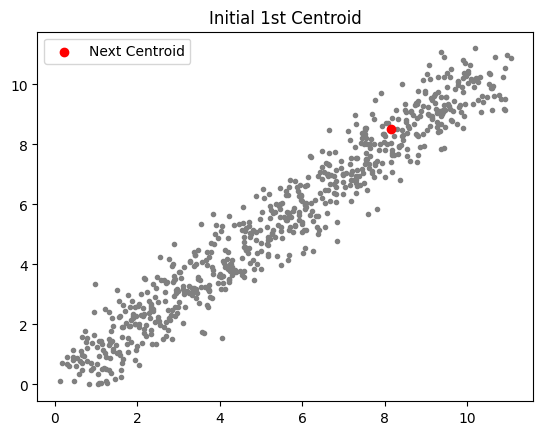

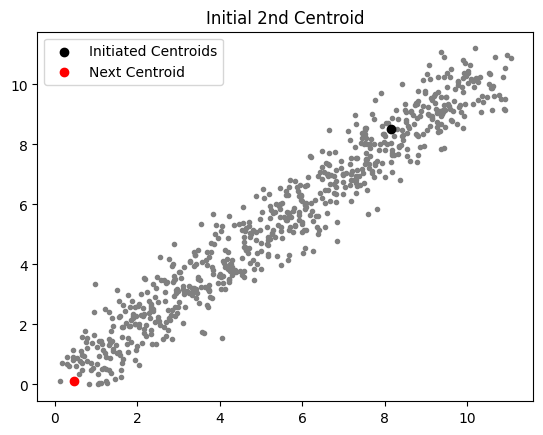

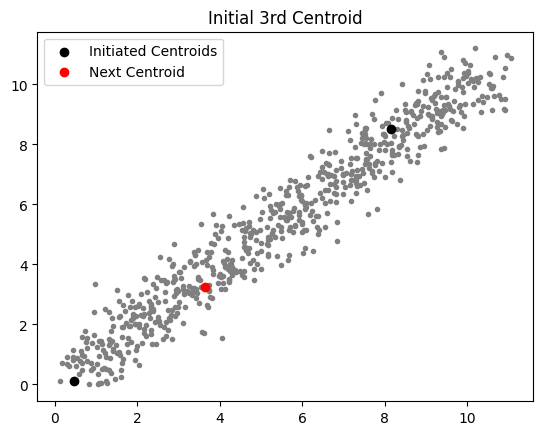

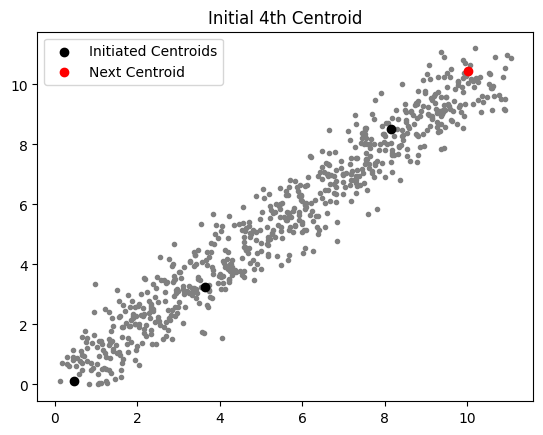

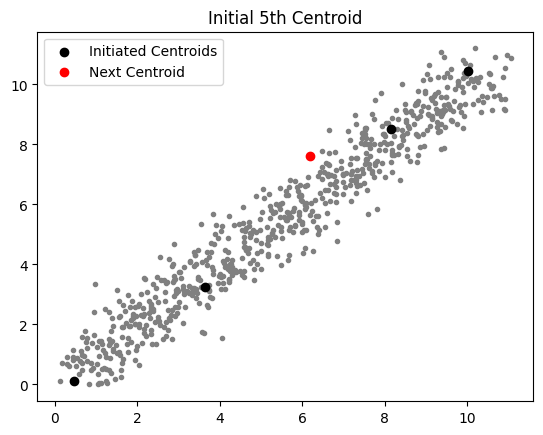

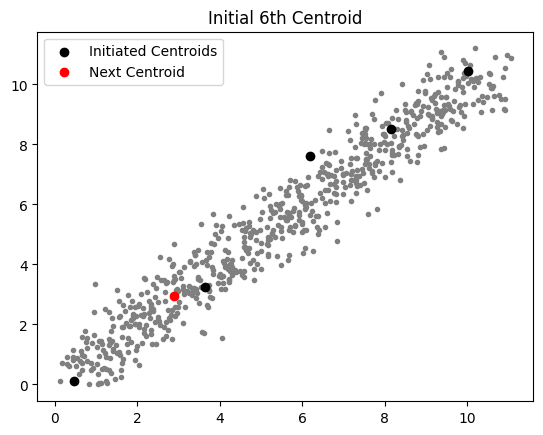

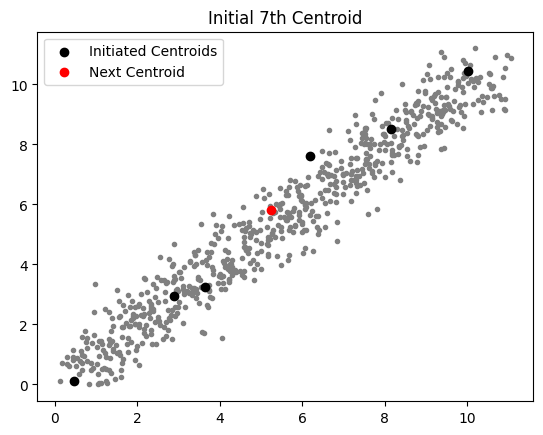

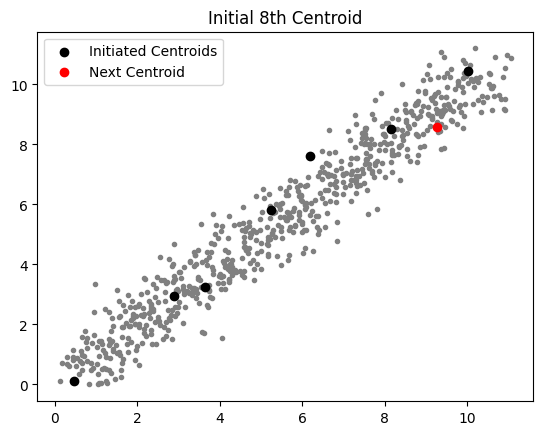

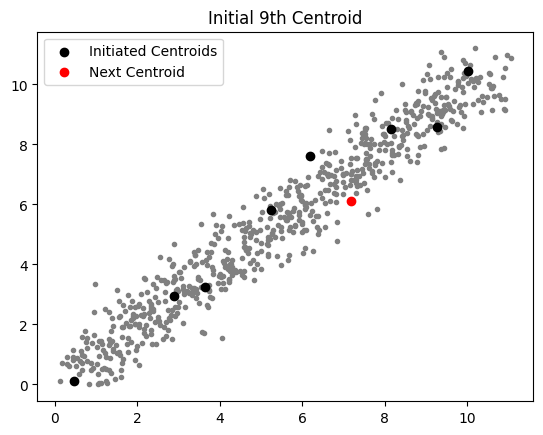

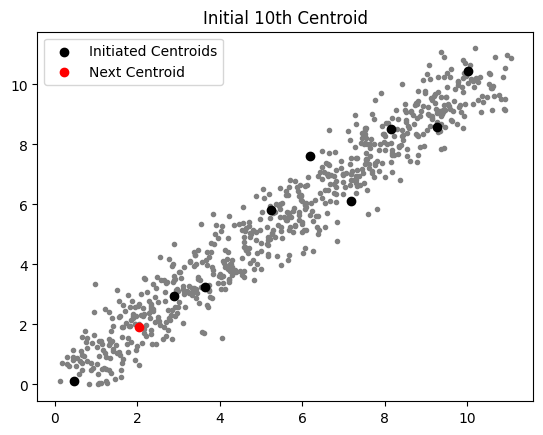

In [ ]:
## Apply federated k-means:

clientdata = x['train']

fkmeans = KMeansFederated(n_clusters=10, seed=None, verbose=False, learning_rate=0.75, sample_fraction=0.7, max_iter=50)
centroids, counts = fkmeans.fit(clientdata)

# Evaluating the clustering
Using the Davies-Bouldin Score, I evaluate the clustering qulity of my federated training data.  

The Davies-Bouldin (DB) Score represents cluster compactness and separation between clusters where a lower score suggests better quality clustering. I.e.: tighter and more separated clusters produce a lower DB score.   

Its method involves the following steps:  


1.   Computing the compactness of data points within clusters:  

$$
S_{i} = \frac{1}{C_{i}} \sum_{x_{n} \in \{c_{i}\}} \left\lVert x_n - \mu_{i} \right\rVert,
$$  

where $C_{i}$ is the set of data points in cluster $i$, $x_{n}$ represents a data point in cluster $i$, and $\mu_{i}$ is the centroid in cluster $i$.
2.   Computing pairwise distances between cluster centroids:  

$$
M_{ij}=\left\lVert \mu_{i}-\mu_{j} \right\rVert,
$$  

where $M_{ij}$ is the matrix entry for the Euclidean distance between centroids in clusters $i$ and $j$.
3.     Computing the average distance between clusters and the diamter of points within each cluster using the values for $S_{i}$ and $M_{i,j}$:  

$$
R_{ij}=\frac{S_{i}+S_{j}}{M_{ij}}, \forall i,j,i\neq j,
$$  

where $R_{ij}$  represents a similarity measure between each cluster.
4.    Finding the maximum similarity measure across all clusters. I.e.: clusters containing the least compact points and with the least distance between their centroids.  

$$
D_{ij}=\max_{j\neq i}R_{ij}.
$$
5.    Computing the final DB index by averaging all of $D_{i}$:  

$$
I_{DB}=\frac{1}{k}\sum_{i=1}^{k} D_{i}.
$$

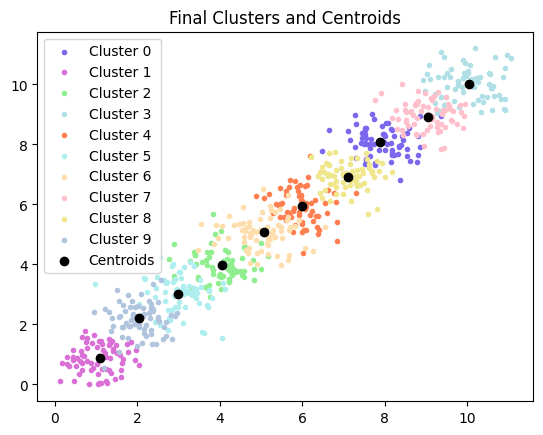

Inter-cluster distances:  [4.86028984 4.93159154 4.89074828 4.99140861 4.86638028 4.85668796
 4.86638028 4.86028984 4.95469162 4.85668796]
Intra-cluster distances:  [2.38717328 2.33647751 2.38263018 2.3710566  2.46482261 2.39862127
 2.4673926  2.42172802 2.36656947 2.40486555]
Davies-Bouldin score:  0.9852673464535805


In [ ]:
## Evaulate

######################
# Edited from utils_stats.py:

def euclidean_dist(x, labels, centroids):
    distances = np.sqrt(np.sum(np.square(x - centroids[labels]), axis=1))
    dist = np.mean(distances)
    return dist

def davies_bouldin(x, labels, centroids, verbose=True):
    # DIY
    NUM_CLUSTERS = centroids.shape[0]
    distances = np.sqrt(np.sum(np.square(x - centroids[labels]), axis=1))

    # centroid distances
    centroid_dist_matrix = np.expand_dims(centroids, axis=0) - np.expand_dims(centroids, axis=1)
    centroid_dist_matrix = np.sqrt(np.sum(np.square(centroid_dist_matrix), axis=2))

    centroid_dist_matrix[range(NUM_CLUSTERS), range(NUM_CLUSTERS)] = float("inf")

    # intra cluster dist
    intra_dist = np.zeros(NUM_CLUSTERS)

    for i in range(NUM_CLUSTERS):
        cluster_mask = (labels == i)
        if np.any(cluster_mask):
            intra_dist[i] = np.mean(distances[cluster_mask])
        else:
            intra_dist[i] = np.nan  # mark empty clusters

    s_ij = np.expand_dims(intra_dist, axis=0) + np.expand_dims(intra_dist, axis=1)
    d_i = np.nanmax(s_ij / centroid_dist_matrix, axis=1)
    db_score = np.nanmean(d_i)
    if verbose:
        print("Inter-cluster distances: ", np.amin(centroid_dist_matrix, axis=1))
        print("Intra-cluster distances: ", intra_dist)
    return db_score

def evaluate(kmeans, x, splits, use_metric='euclidean', federated=True, verbose=False):
    scores = {}
    centroids = kmeans.cluster_centers_
    for split in splits:
        if federated:
            filtered_data=[]
            for arr in x[split]:
                arr = np.asarray(arr)
                if arr.ndim == 0:
                    # Convert scalar to 1D array with single element
                    arr = arr.reshape(1)
                filtered_data.append(arr)
#            print([arr.shape if hasattr(arr, 'shape') else 'scalar' for arr in x[split]])
            x[split] = np.concatenate(filtered_data, axis=0)
            if x[split].ndim == 1:
                x[split] = x[split].reshape(-1, 1)
            labels = kmeans.predict(x[split])
            plot_final(x[split], centroids, labels)
#        if verbose:
#            print(split, use_metric)
        if "davies_bouldin" == use_metric:
            score = davies_bouldin(x[split], labels, centroids, verbose)
        elif "silhouette" == use_metric:
            # silhouette (takes forever) -> need metric with linear execution time wrt data size
            score = metrics.silhouette_score(x[split], labels)
        else:
            assert use_metric == 'euclidean'
            score = euclidean_dist(x[split], labels, centroids)
        scores[split] = score
        if verbose:
            print('Davies-Bouldin score: ', score)
    return scores

######################

scores = evaluate(fkmeans, x, splits=['train'], use_metric='davies_bouldin', federated=True, verbose=True)

## Analysis of data

The above graph shows distinct clusters, although their boundaries are not well separated. This is reflected in the inter-cluster distances which remain consistant across all clusters, as do the intra-cluster distances. The Davies-Bouldin (DB) score at $≈0.985$. For an ideal score, I would seek a score as close to zero as possible, but a DB score less than 1 is within an acceptable range for initial testing.  

Experimentation revealed an optimum learning rate lies between 0.7 and 0.8, and an optimum sample fraction between 0.7 and 1.0. Increasing the maximum number of iterations didn't improve the intra- / inter-cluster distances, nor the DB score.  

---

Note:  
Increasing the number of clusters to 11 increased the DB score to $≈1.446$.  
Increasing the number of clusters to 12 increased the DB score to $≈1.837$.  
Increasing the number of clusters to 13 increased the DB score to $≈2.110$.    
From this, I conclude that increasing the number of clusters will not improve the quality of clustering.  

Decreasing the number of clusters to 9 gave a DB score of $≈0.985$, which is no different than for 10 clusters.  
Decreasing the number of clusters to 8 gave a DB score of $≈0.922$, which is slightly better.  
Decreasing the number of clusters to 7 gave a DB score of $≈0.878$, which is an even greater impovement.  
Decreasing the number of clusters to 6 gave a DB score of $≈0.828$.  
Decreasing the number of clusters to 5 gave a DB score of $≈0.707$.  
Decreasing the number of clusters to 4 gave a DB score of $≈0.664$.  
At this point, we should weigh the pros and cons of decreasing the number of clusters, as although it improves the DB score, the inter-cluster distances become less consistant and the data may become less useful. After all, the logical conclusion would be to set the number of clusters to 1, which does lead to a DB score of zero, but also negates the point of clustering.